In [4]:
!pip install ultralytics
from ultralytics import YOLO
model = YOLO("yolo11n.pt")

TRAIN Data Visualization is in process...

Visualization saved as train_visualization.png in the working directory.
VALID Data Visualization is in process...

Visualization saved as valid_visualization.png in the working directory.
TEST Data Visualization is in process...

Visualization saved as test_visualization.png in the working directory.
Data analysis is in process...



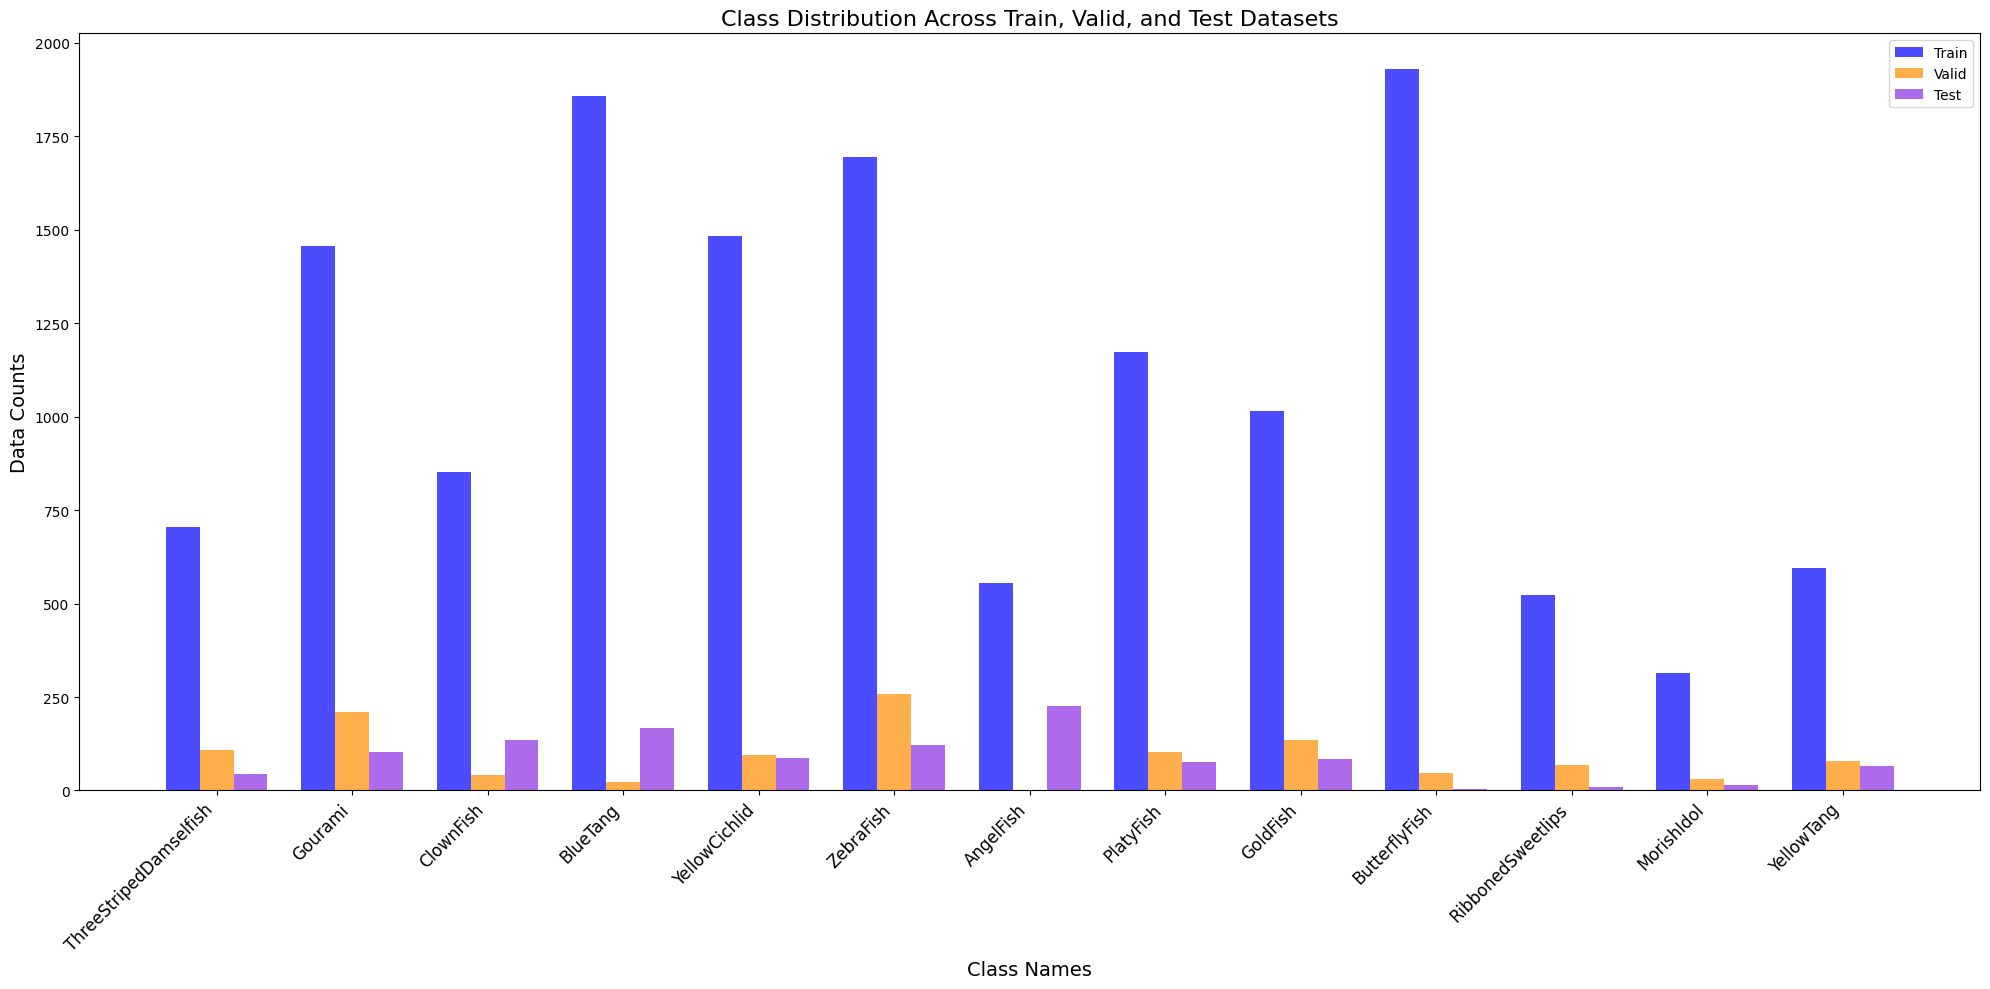

Data analysis saved as data_analysis.png in the working directory.


In [14]:
import os
import cv2
import yaml
import random
import numpy as np
from PIL import Image
from glob import glob
from matplotlib import pyplot as plt
from torchvision import transforms as T


class Visualization:

    def __init__(self, root, data_types, n_ims, rows, cmap=None):
        self.n_ims, self.rows = n_ims, rows
        self.cmap, self.data_types = cmap, data_types
        self.colors = ["firebrick", "darkorange", "blueviolet"]

        self.get_cls_names()
        self.get_bboxes()

    def get_cls_names(self):
        with open(f"{root}/data.yaml", 'r') as file:
            data = yaml.safe_load(file)
        class_names = data['names']
        self.class_dict = {index: name for index, name in enumerate(class_names)}

    def get_bboxes(self):
        self.vis_datas, self.analysis_datas, self.im_paths = {}, {}, {}
        for data_type in self.data_types:
            all_bboxes, all_analysis_datas = [], {}
            im_paths = glob(f"{root}/{data_type}/images/*")

            for idx, im_path in enumerate(im_paths):
                bboxes = []
                if ".png" in im_path:
                    lbl_path = im_path.replace(".png", ".txt")
                elif ".jpg" in im_path:
                    lbl_path = im_path.replace(".jpg", ".txt")
                lbl_path = lbl_path.replace(f"{data_type}/images/", f"{data_type}/labels/")
                if not os.path.isfile(lbl_path):
                    continue
                meta_data = open(lbl_path).readlines()
                for data in meta_data:
                    parts = data.strip().split()[:5]
                    cls_name = self.class_dict[int(parts[0])]
                    bboxes.append([cls_name] + [float(x) for x in parts[1:]])
                    if cls_name not in all_analysis_datas:
                        all_analysis_datas[cls_name] = 1
                    else:
                        all_analysis_datas[cls_name] += 1
                all_bboxes.append(bboxes)

            self.vis_datas[data_type] = all_bboxes
            self.analysis_datas[data_type] = all_analysis_datas
            self.im_paths[data_type] = im_paths

    def plot(self, rows, cols, count, im_path, bboxes):
        plt.subplot(rows, cols, count)
        or_im = np.array(Image.open(im_path).convert("RGB"))
        height, width, _ = or_im.shape

        for bbox in bboxes:
            class_id, x_center, y_center, w, h = bbox

            x_min = int((x_center - w / 2) * width)  # x_min
            y_min = int((y_center - h / 2) * height)  # y_min
            x_max = int((x_center + w / 2) * width)  # x_max
            y_max = int((y_center + h / 2) * height)  # y_max

            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            cv2.rectangle(img=or_im, pt1=(x_min, y_min), pt2=(x_max, y_max), color=color, thickness=3)
        plt.imshow(or_im)
        plt.axis("off")
        plt.title(f"There is (are) {len(bboxes)} object(s) in the image.")

        return count + 1

    def vis(self, save_name):
        print(f"{save_name.upper()} Data Visualization is in process...\n")
        assert self.cmap in ["rgb", "gray"], "Please choose rgb or gray cmap"
        cols = self.n_ims // self.rows
        count = 1

        plt.figure(figsize=(25, 20))
        indices = [random.randint(0, len(self.vis_datas[save_name]) - 1) for _ in range(self.n_ims)]

        for idx, index in enumerate(indices):
            if count == self.n_ims + 1:
                break
            im_path, bboxes = self.im_paths[save_name][index], self.vis_datas[save_name][index]
            count = self.plot(self.rows, cols, count, im_path=im_path, bboxes=bboxes)

        plt.savefig(f"{save_name}_visualization.png", bbox_inches="tight")
        plt.close()
        print(f"Visualization saved as {save_name}_visualization.png in the working directory.")

    def data_analysis(self):
        print("Data analysis is in process...\n")
    
        # Prepare a unified dataset for train, valid, and test
        all_data = {}
        for data_type in self.data_types:
            for cls_name, count in self.analysis_datas[data_type].items():
                if cls_name not in all_data:
                    all_data[cls_name] = [0, 0, 0]
                index = self.data_types.index(data_type)
                all_data[cls_name][index] = count
    
        # Plotting
        cls_names = list(all_data.keys())
        counts = np.array(list(all_data.values())).T  # Transpose to separate train, valid, and test counts
        indices = np.arange(len(cls_names))
        bar_width = 0.25  # Adjust bar width for clear separation
    
        # Create the bar chart
        plt.figure(figsize=(20, 10))
        plt.bar(indices, counts[0], width=bar_width, label="Train", color="blue", alpha=0.7)
        plt.bar(indices + bar_width, counts[1], width=bar_width, label="Valid", color="darkorange", alpha=0.7)
        plt.bar(indices + 2 * bar_width, counts[2], width=bar_width, label="Test", color="blueviolet", alpha=0.7)
    
        # Customize the plot
        plt.xlabel("Class Names", fontsize=14)
        plt.ylabel("Data Counts", fontsize=14)
        plt.title("Class Distribution Across Train, Valid, and Test Datasets", fontsize=16)
        plt.xticks(indices + bar_width, cls_names, rotation=45, ha='right', fontsize=12)
        plt.legend()
        plt.tight_layout()
    
        # Save the plot
        plt.savefig("data_analysis_train_test_valid.png", bbox_inches="tight")
        plt.show()
        plt.close()
        print("Data analysis saved as data_analysis.png in the working directory.")


    def visualization(self):
        for save_name in self.data_types:
            self.vis(save_name)

    def analysis(self):
        self.data_analysis()



# Initialize and run the visualization
root = "/kaggle/input/fish-dataset"
vis = Visualization(root=root, data_types=["train", "valid", "test"], n_ims=20, rows=5, cmap="rgb")
vis.visualization()
vis.analysis()


In [15]:
train_results = model.train(
    data=f"{root}/data.yaml",  # path to dataset YAML
    epochs=10,  # number of training epochs
    imgsz=480,  # training image size
    device=[0,1])  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/fish-dataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=[0, 1], workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

100%|██████████| 755k/755k [00:00<00:00, 17.7MB/s]


Overriding model.yaml nc=80 with nc=13

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

Image saved as /kaggle/working/inference_results/results.png


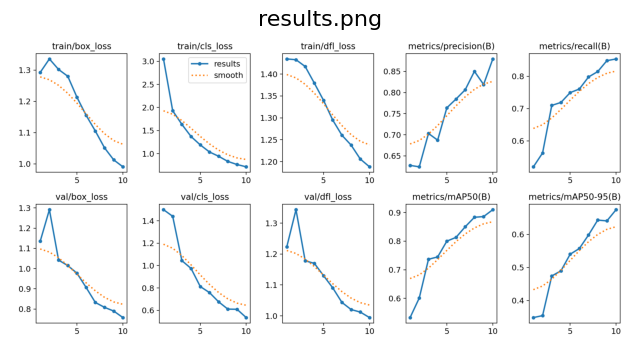

Image saved as /kaggle/working/inference_results/P_curve.png


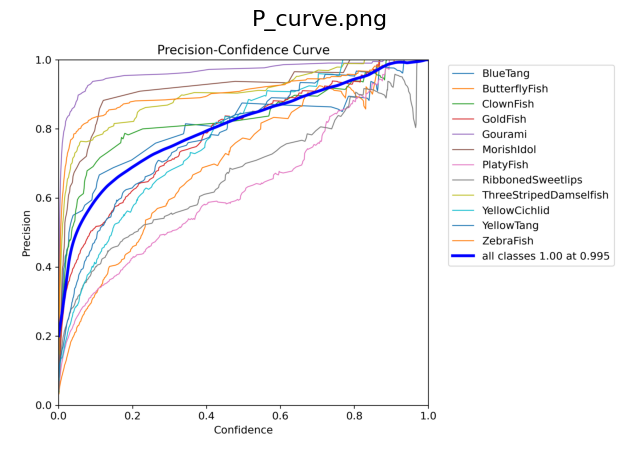

Image saved as /kaggle/working/inference_results/PR_curve.png


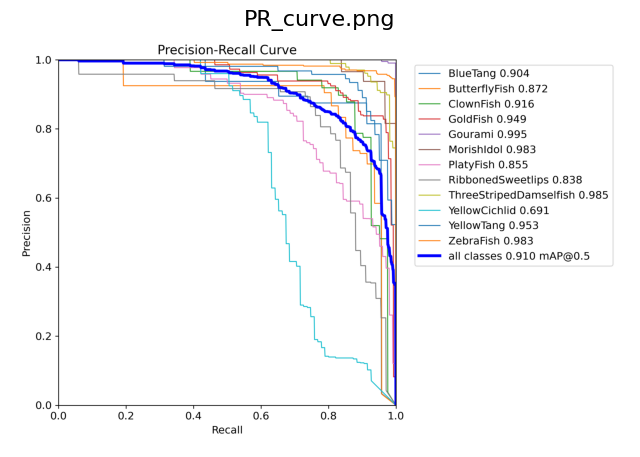

Image saved as /kaggle/working/inference_results/val_batch0_pred.jpg


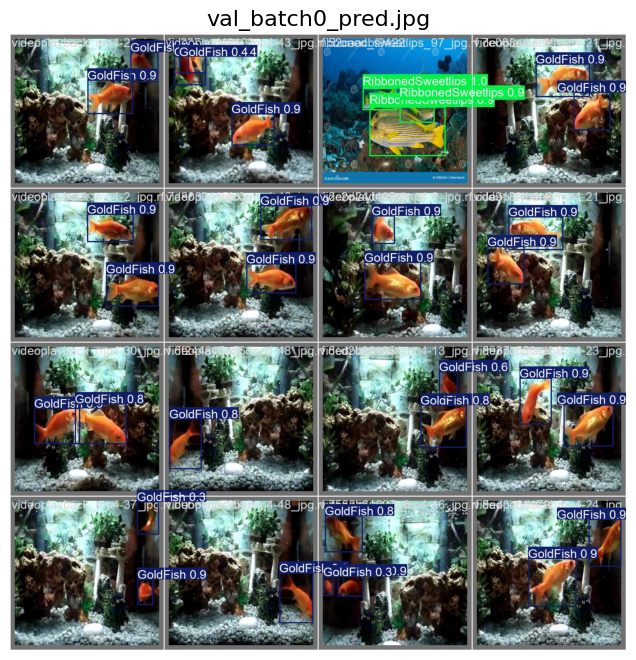

Inference visualization saved as /kaggle/working/inference_results/inference_visualization.png


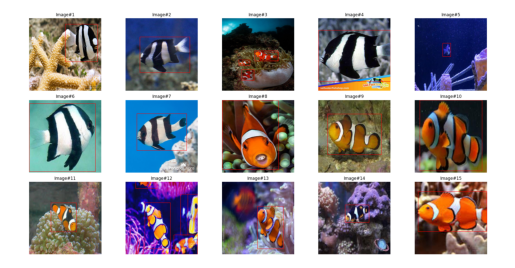

In [16]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define paths to your images
paths = [
    "runs/detect/train/results.png",
    "runs/detect/train/P_curve.png",
    "runs/detect/train/PR_curve.png",
    "runs/detect/train/val_batch0_pred.jpg"
]

# Create directory for saving images if it doesn't exist
save_dir = '/kaggle/working/inference_results'
os.makedirs(save_dir, exist_ok=True)

# Function to open, save, and display images
def process_and_save_image(image_path, save_name):
    try:
        # Open the image
        img = Image.open(image_path)

        # Save the image in the specified directory with proper name
        save_path = os.path.join(save_dir, save_name)
        img.save(save_path, format="PNG")  # You can adjust format if necessary
        print(f"Image saved as {save_path}")

        # Display the image in the notebook
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{save_name}", fontsize=16)
        plt.show()
    except Exception as e:
        print(f"An error occurred with {image_path}: {e}")

# Process and save each image
process_and_save_image(paths[0], "results.png")
process_and_save_image(paths[1], "P_curve.png")
process_and_save_image(paths[2], "PR_curve.png")
process_and_save_image(paths[3], "val_batch0_pred.jpg")

# Now run the inference visualization
inference_results = model(f"{root}/test/images", device=0, verbose=False)

# Function to visualize inference results and save them
def inference_vis(res, n_ims, rows, save_path):
    cols = n_ims // rows
    plt.figure(figsize=(20, 10))
    for idx, r in enumerate(res):
        if idx == n_ims: break
        plt.subplot(rows, cols, idx + 1)
        or_im_rgb = np.array(Image.open(r.path).convert("RGB"))
        if idx == n_ims: break    
        for i in r:
            for bbox in i.boxes:
                box = bbox.xyxy[0]
                x1, y1, x2, y2 = box
                coord1, coord2 = (int(x1), int(y1)), (int(x2), int(y2))
                cv2.rectangle(or_im_rgb, coord1, coord2, color=(255, 0, 0), thickness=2)
        plt.imshow(or_im_rgb)
        plt.title(f"Image#{idx + 1}")
        plt.axis("off")

    # Save the visualization image
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    print(f"Inference visualization saved as {save_path}")

# Set path to save the inference visualization
inference_vis_save_path = os.path.join(save_dir, "inference_visualization.png")

# Visualize and save inference results
inference_vis(res=inference_results, n_ims=15, rows=3, save_path=inference_vis_save_path)

# Display the saved visualization
inference_vis_img = Image.open(inference_vis_save_path)
plt.imshow(inference_vis_img)
plt.axis("off")
plt.show()
